# Credit Approval Data Set

## 1. Visão Geral e Objetivos

#### O objetivo desta análise é demonstrar as técnicas estudadas durante o curso de Pós-Graduação oferecido pela PUC-MG, para mensurar e comparar diferentes métricas de avaliação dos algortimos de classificação. O conjunto de dados utilizado - Credit Approval Data Set - utilizado está disponível no UCI Machine Learning Repository e podem ser acessados pelo link: http://archive.ics.uci.edu/ml/datasets/credit+approval.

#### A descrição das features pode ser acessada através do link: http://rstudio-pubs-static.s3.amazonaws.com/73039_9946de135c0a49daa7a0a9eda4a67a72.html

#### Esta análise demonstra várias técnicas analíticas para examinar a decisão de uma empresa de aprovar ou negar pedidos de cartão de crédito. O modelo final criado a partir dessa análise é um modelo de LogisticRegression. Este modelo foi capaz de prever o resultado de um aplicativo de crédito com 81,16% de acurácia, o que foi um desempenho melhor do que os  outros modelos avaliados. As métricas precision, recall e F-1 score também se apresentaram superiores em relação aos demais modelos.


## 2. Configuração do projeto

In [2]:
import joblib
import os
import urllib

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


#pacotes incluídos
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB



print('Matplotlib version: {}'.format(matplotlib.__version__))
print('Numpy version: {}'.format(np.__version__))
print('Pandas version: {}'.format(pd.__version__))
print('Sklearn version: {}'.format(sklearn.__version__))
print('Seaborn version: {}'.format(sns.__version__))

DATA_ROOT = 'http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/'
DATA_URL = DATA_ROOT + 'crx.data'

DATA_PATH = os.path.join('..','data','raw')
DATA_FILE = 'crx.csv'
CRX_DATA = os.path.join (DATA_PATH, DATA_FILE)

DEPLOY_PATH = os.path.join ('..','model')
DEPLOY_FILE = 'finalized_model.sav'

SEED = 42

print("Configuração completa!")

Matplotlib version: 3.3.2
Numpy version: 1.19.2
Pandas version: 1.1.3
Sklearn version: 0.23.2
Seaborn version: 0.11.0
Configuração completa!


## 3. Carga de dados

In [3]:
def download_data(data_url=DATA_URL, data_path=DATA_PATH, data_file=DATA_FILE):
    os.makedirs(data_path, exist_ok=True)
    local_path = os.path.join(data_path, data_file)
    urllib.request.urlretrieve(DATA_URL, local_path)

In [4]:
download_data(DATA_URL, DATA_PATH, DATA_FILE)

In [5]:
def load_data(data_path, data_file):
    local_path = os.path.join(data_path, data_file)
    return pd.read_csv(local_path,header=None, names = ['Gender', 'Age','Debt', 
                                                       'Married','BankCustomer', 'EducationLevel',
                                                       'Ethnicity','YearsEmployed','PriorDefault',
                                                       'Employed','CreditScore','DriversLicense',
                                                       'Citizen','ZipCode','Income','ApprovalStatus'])

In [6]:
crx_data = load_data(DATA_PATH, DATA_FILE)

## 4. Análise Exploratória dos dados

In [7]:
crx_data.info()
print("-"*55)
print('O dataset tem {} linhas e {} colunas'.format(crx_data.shape[0], crx_data.shape[1]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          690 non-null    object 
 1   Age             690 non-null    object 
 2   Debt            690 non-null    float64
 3   Married         690 non-null    object 
 4   BankCustomer    690 non-null    object 
 5   EducationLevel  690 non-null    object 
 6   Ethnicity       690 non-null    object 
 7   YearsEmployed   690 non-null    float64
 8   PriorDefault    690 non-null    object 
 9   Employed        690 non-null    object 
 10  CreditScore     690 non-null    int64  
 11  DriversLicense  690 non-null    object 
 12  Citizen         690 non-null    object 
 13  ZipCode         690 non-null    object 
 14  Income          690 non-null    int64  
 15  ApprovalStatus  690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB
---------------------

In [8]:
crx_data.head()

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,ApprovalStatus
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [9]:
crx_data.tail()

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,ApprovalStatus
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,00260,0,-
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,00200,394,-
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,00200,1,-
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,00280,750,-
689,b,35.00,3.375,u,g,c,h,8.29,f,f,0,t,g,00000,0,-


In [10]:
crx_data.describe()

,Debt,YearsEmployed,CreditScore,Income
count,690.000000,690.000000,690.00000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507
std,4.978163,3.346513,4.86294,5210.102598
min,0.000000,0.000000,0.00000,0.000000
25%,1.000000,0.165000,0.00000,0.000000
50%,2.750000,1.000000,0.00000,5.000000
75%,7.207500,2.625000,3.00000,395.500000
max,28.000000,28.500000,67.00000,100000.000000


### 4.1 Verificando "missing values"

Registros ausentes por coluna
> Gender, ausentes: 0 (0.00%)
> Age, ausentes: 0 (0.00%)
> Debt, ausentes: 0 (0.00%)
> Married, ausentes: 0 (0.00%)
> BankCustomer, ausentes: 0 (0.00%)
> EducationLevel, ausentes: 0 (0.00%)
> Ethnicity, ausentes: 0 (0.00%)
> YearsEmployed, ausentes: 0 (0.00%)
> PriorDefault, ausentes: 0 (0.00%)
> Employed, ausentes: 0 (0.00%)
> CreditScore, ausentes: 0 (0.00%)
> DriversLicense, ausentes: 0 (0.00%)
> Citizen, ausentes: 0 (0.00%)
> ZipCode, ausentes: 0 (0.00%)
> Income, ausentes: 0 (0.00%)
> ApprovalStatus, ausentes: 0 (0.00%)


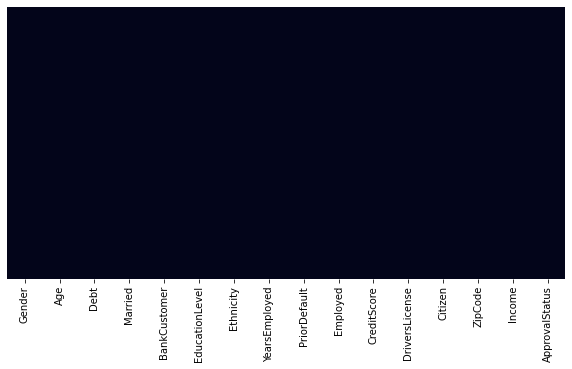

In [11]:
#Verificando a contagem de registros ausentes
data = crx_data

print('Registros ausentes por coluna')
for c in range(data.shape[1]):
    missing   = data[[data.columns[c]]].isnull().sum()
    percentual = missing / data.shape[0] * 100
    print ("> %s, ausentes: %d (%.2f%%)" % (data.columns[c], missing, percentual) )
plt.figure(figsize=(10,5))
_ = sns.heatmap(data.isnull(),yticklabels=False, cbar=False)

Registros iguais a zero por coluna
> A coluna Gender tem 0 (0.00%) registros iguais a zero.
> A coluna Age tem 0 (0.00%) registros iguais a zero.
> A coluna Debt tem 19 (2.75%) registros iguais a zero.
> A coluna Married tem 0 (0.00%) registros iguais a zero.
> A coluna BankCustomer tem 0 (0.00%) registros iguais a zero.
> A coluna EducationLevel tem 0 (0.00%) registros iguais a zero.
> A coluna Ethnicity tem 0 (0.00%) registros iguais a zero.
> A coluna YearsEmployed tem 70 (10.14%) registros iguais a zero.
> A coluna PriorDefault tem 0 (0.00%) registros iguais a zero.
> A coluna Employed tem 0 (0.00%) registros iguais a zero.
> A coluna CreditScore tem 395 (57.25%) registros iguais a zero.
> A coluna DriversLicense tem 0 (0.00%) registros iguais a zero.
> A coluna Citizen tem 0 (0.00%) registros iguais a zero.
> A coluna ZipCode tem 0 (0.00%) registros iguais a zero.
> A coluna Income tem 295 (42.75%) registros iguais a zero.
> A coluna ApprovalStatus tem 0 (0.00%) registros iguais a

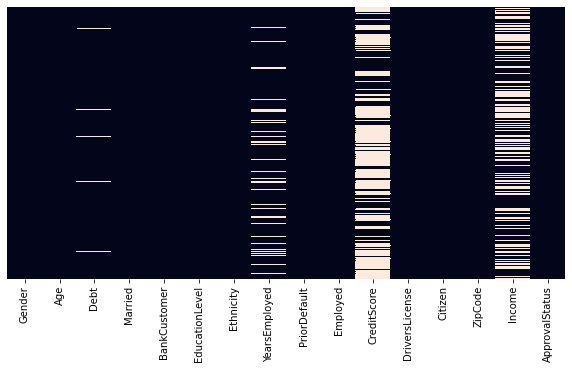

In [12]:
#Verificando a contagem de registros iguais a zero
data = crx_data

print('Registros iguais a zero por coluna')
for c in range(data.shape[1]):
    count_zeros   = (data[[data.columns[c]]]==0).sum()
    percentual = count_zeros / data.shape[0] * 100
    print ("> A coluna %s tem %d (%.2f%%) registros iguais a zero." % (data.columns[c], count_zeros, percentual) )

plt.figure(figsize=(10,5))
_ = sns.heatmap((data == 0),yticklabels=False, cbar=False)

Registros iguais a '?' por coluna
> A coluna Gender tem 12 (1.74%) registros iguais a '?'.
> A coluna Age tem 12 (1.74%) registros iguais a '?'.
> A coluna Debt tem 0 (0.00%) registros iguais a '?'.
> A coluna Married tem 6 (0.87%) registros iguais a '?'.
> A coluna BankCustomer tem 6 (0.87%) registros iguais a '?'.
> A coluna EducationLevel tem 9 (1.30%) registros iguais a '?'.
> A coluna Ethnicity tem 9 (1.30%) registros iguais a '?'.
> A coluna YearsEmployed tem 0 (0.00%) registros iguais a '?'.
> A coluna PriorDefault tem 0 (0.00%) registros iguais a '?'.
> A coluna Employed tem 0 (0.00%) registros iguais a '?'.
> A coluna CreditScore tem 0 (0.00%) registros iguais a '?'.
> A coluna DriversLicense tem 0 (0.00%) registros iguais a '?'.
> A coluna Citizen tem 0 (0.00%) registros iguais a '?'.
> A coluna ZipCode tem 13 (1.88%) registros iguais a '?'.
> A coluna Income tem 0 (0.00%) registros iguais a '?'.
> A coluna ApprovalStatus tem 0 (0.00%) registros iguais a '?'.


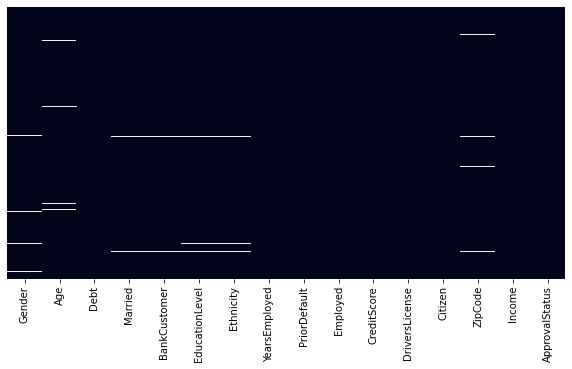

In [13]:
#Verificando a contagem de registros iguais a '?'
data = crx_data

print("Registros iguais a '?' por coluna")
for c in range(data.shape[1]):
    count   = (data[[data.columns[c]]]=='?').sum()
    percentual = count / data.shape[0] * 100
    print ("> A coluna %s tem %d (%.2f%%) registros iguais a '?'." % (data.columns[c], count, percentual) )

plt.figure(figsize=(10,5))
_ = sns.heatmap((data == "?"),yticklabels=False, cbar=False)

Registros iguais a '?' por coluna
> A coluna Gender tem 0 (0.00%) registros iguais a '?'.
> A coluna Age tem 0 (0.00%) registros iguais a '?'.
> A coluna Debt tem 0 (0.00%) registros iguais a '?'.
> A coluna Married tem 0 (0.00%) registros iguais a '?'.
> A coluna BankCustomer tem 0 (0.00%) registros iguais a '?'.
> A coluna EducationLevel tem 0 (0.00%) registros iguais a '?'.
> A coluna Ethnicity tem 0 (0.00%) registros iguais a '?'.
> A coluna YearsEmployed tem 0 (0.00%) registros iguais a '?'.
> A coluna PriorDefault tem 0 (0.00%) registros iguais a '?'.
> A coluna Employed tem 0 (0.00%) registros iguais a '?'.
> A coluna CreditScore tem 0 (0.00%) registros iguais a '?'.
> A coluna DriversLicense tem 0 (0.00%) registros iguais a '?'.
> A coluna Citizen tem 0 (0.00%) registros iguais a '?'.
> A coluna ZipCode tem 0 (0.00%) registros iguais a '?'.
> A coluna Income tem 0 (0.00%) registros iguais a '?'.
> A coluna ApprovalStatus tem 0 (0.00%) registros iguais a '?'.


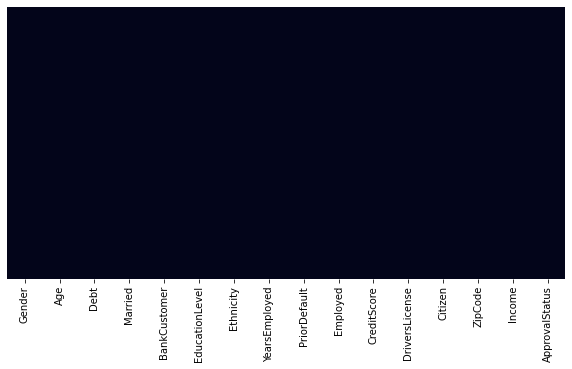

In [14]:
# Substituir os '?'s por NaN
data = data.replace('?', np.nan)

# Verificar valores iguais a '?' novamente
print("Registros iguais a '?' por coluna")
for c in range(data.shape[1]):
    count   = (data[[data.columns[c]]]=='?').sum()
    percentual = count / data.shape[0] * 100
    print ("> A coluna %s tem %d (%.2f%%) registros iguais a '?'." % (data.columns[c], count, percentual) )

plt.figure(figsize=(10,5))
_ = sns.heatmap((data == "?"),yticklabels=False, cbar=False)

In [15]:
# Imputar os valores ausentes com imputação da média
data.fillna(data.mean(), inplace=True)

# Verificar o número de NaNs no conjunto de dados
data.isnull().values.sum()

67

In [16]:
# Iterar sobre cada coluna de dados
for col in data.columns:
    # Check if the column is of object type
    if data[col].dtypes == 'object':
        # Impute with the most frequent value
        data = data.fillna(data[col].value_counts().index[0])

# Verificar o número de NaNs no conjunto de dados
data.isnull().values.sum()

0

In [17]:
# Importar LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Instanciar LabelEncoder
le = LabelEncoder()

# Iterar todos os valores de cada coluna e extrair seus dtypes
for col in data.columns:
    # Comparar se o dtype é object
    if data[col].dtype=='object':
    # Usar LabelEncoder para fazer a transformação numérica
        data[col]=le.fit_transform(data[col])

### 4.2 Correlação e distribuição dos dados

In [18]:
#predictors
X = data.drop(['ApprovalStatus'], axis=1)
#target
y = data['ApprovalStatus']

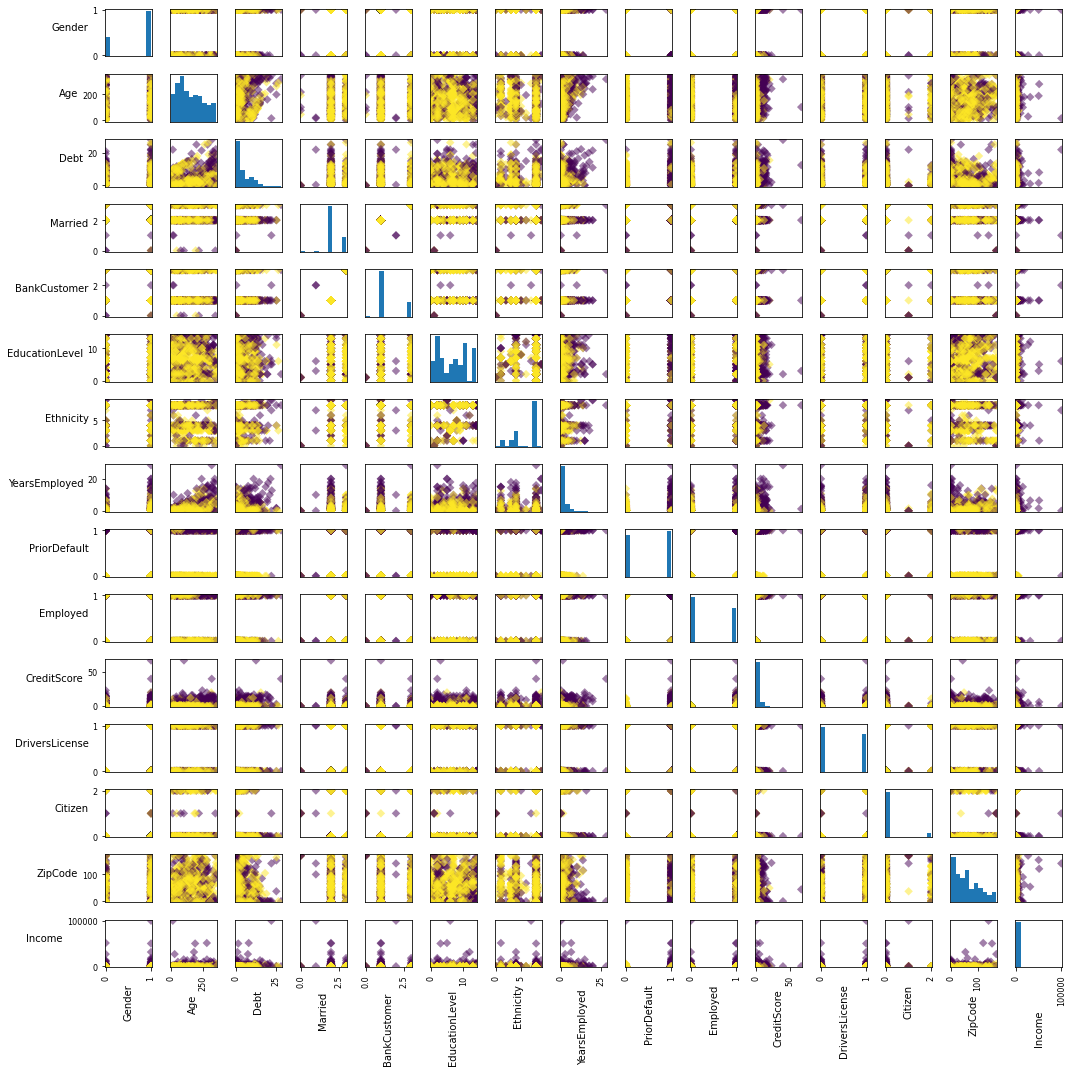

In [19]:
cores = y.astype('category').cat.codes
_=pd.plotting.scatter_matrix( X, c=cores, figsize=[15,15], marker='D')

for ax in _.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
plt.tight_layout()

In [20]:
# calcular a matriz de correlação
corr = X.corr()

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])]

corr.style.background_gradient()\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Passe o mouse para ampliar")\
    .set_precision(2)\
    .set_table_styles(magnify())

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income
Gender,1.00,0.06,-0.04,0.07,0.07,-0.01,0.04,0.09,-0.03,-0.08,-0.02,0.05,0.09,0.10,-0.00
Age,0.06,1.00,0.14,-0.07,-0.09,0.03,-0.19,0.39,0.20,0.05,0.16,0.08,0.00,-0.00,0.02
Debt,-0.04,0.14,1.00,-0.05,-0.07,0.02,-0.02,0.30,0.24,0.17,0.27,-0.01,-0.12,-0.26,0.12
Married,0.07,-0.07,-0.05,1.00,0.94,0.00,0.06,-0.05,-0.08,-0.11,-0.08,0.03,-0.09,-0.09,-0.10
BankCustomer,0.07,-0.09,-0.07,0.94,1.00,-0.04,-0.00,-0.07,-0.13,-0.16,-0.11,0.02,-0.04,-0.02,-0.02
EducationLevel,-0.01,0.03,0.02,0.00,-0.04,1.00,0.04,0.04,0.11,0.13,0.01,0.08,-0.01,0.07,0.01
Ethnicity,0.04,-0.19,-0.02,0.06,-0.00,0.04,1.00,-0.07,-0.00,0.03,-0.02,0.02,-0.02,-0.06,-0.01
YearsEmployed,0.09,0.39,0.30,-0.05,-0.07,0.04,-0.07,1.00,0.35,0.22,0.32,0.14,-0.02,-0.11,0.05
PriorDefault,-0.03,0.20,0.24,-0.08,-0.13,0.11,-0.00,0.35,1.00,0.43,0.38,0.09,-0.11,-0.10,0.09
Employed,-0.08,0.05,0.17,-0.11,-0.16,0.13,0.03,0.22,0.43,1.00,0.57,0.02,-0.24,-0.09,0.08


In [21]:
#Seleção de Features
data = data.drop(['Gender',
                  'Age',
                  'Married', 
                  'BankCustomer',
                  'Ethnicity',
                  'DriversLicense',
                  'Citizen',
                  'ZipCode'], axis=1)

In [22]:
data.head()

,Debt,EducationLevel,YearsEmployed,PriorDefault,Employed,CreditScore,Income,ApprovalStatus
0,0.000,13,1.25,1,1,1,0,0
1,4.460,11,3.04,1,1,6,560,0
2,0.500,11,1.50,1,0,0,824,0
3,1.540,13,3.75,1,1,5,3,0
4,5.625,13,1.71,1,0,0,0,0


## 5. Particionamento do dataset

In [23]:
#predictors
X = data.drop(['ApprovalStatus'], axis=1)
#target
y = data['ApprovalStatus']

In [24]:
#split (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3, stratify=y, random_state=SEED)

## 5. Transformação dos dados

In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
X_scaled = pd.DataFrame(scaler.fit_transform(X))
X_scaled.columns = X.columns

In [26]:
X_scaled.head()

,Debt,EducationLevel,YearsEmployed,PriorDefault,Employed,CreditScore,Income
0,0.000000,0.928571,0.043860,1.0,1.0,0.014925,0.00000
1,0.159286,0.785714,0.106667,1.0,1.0,0.089552,0.00560
2,0.017857,0.785714,0.052632,1.0,0.0,0.000000,0.00824
3,0.055000,0.928571,0.131579,1.0,1.0,0.074627,0.00003
4,0.200893,0.928571,0.060000,1.0,0.0,0.000000,0.00000


## 7. Criação dos classificadores

In [27]:
def build_classifiers():
    """Retorna uma lista com os classificadores que serão avaliados"""
    classifiers=[]
    classifiers.append(
        ('KNN',                                          #nome do classificador
         KNeighborsClassifier(),                         #instância do classificador 
         {'n_neighbors':range(1,33,2)}                   #hiperparametros
        )
    )
    classifiers.append(
        ('LR',                   
         LogisticRegression(max_iter=1000),
         {'penalty':['l2'], 'C':[100, 10, 1, 0.1, 0.01]}                 
        )
    )
    classifiers.append(
        ('SVM',                   
         SVC(),   
         {'kernel':['rbf'],
          'C':[2**(-5),2**5]}                 
        )
    )
    classifiers.append(
        ('DT',                   
         DecisionTreeClassifier(random_state=SEED),   
         {'max_depth':[2,4,6,8,10,12]}   
        )
    )
    classifiers.append(
        ('RF',                   
         RandomForestClassifier(random_state=SEED),   
         {'n_estimators':[10, 50, 100]}   
        )
    )
    classifiers.append(
        ('GNB',                   
         GaussianNB(),
         {}
        )
    )
    return classifiers

## 8. Desempenho dos classificadores

### 8.1. Avaliação dos classificadores em treino

In [28]:
classifiers = build_classifiers()
results_train = []
names  = []
for name, model, parameters in classifiers:
    print('>> classifier name: {}'.format(name))
    gs = GridSearchCV(estimator=model, param_grid=parameters, refit=True, verbose=0)
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    cv = cross_val_score(gs, X_train, y_train, cv=kf, scoring='accuracy')
    print('Mean Accuracy: {:.2f}%, Standard Deviation: {}'.format(cv.mean()*100,cv.std()))
    results_train.append(cv)
    names.append(name)

>> classifier name: KNN
Mean Accuracy: 74.12%, Standard Deviation: 0.04328012940379504
>> classifier name: LR
Mean Accuracy: 87.15%, Standard Deviation: 0.030235973275220682
>> classifier name: SVM
Mean Accuracy: 68.32%, Standard Deviation: 0.0434391990937043
>> classifier name: DT
Mean Accuracy: 85.71%, Standard Deviation: 0.024285662915783345
>> classifier name: RF
Mean Accuracy: 86.75%, Standard Deviation: 0.03014766271692925
>> classifier name: GNB
Mean Accuracy: 77.85%, Standard Deviation: 0.01350492510494589


### 8.2. Avaliação dos classificadores em teste

In [29]:
results_test = []
names = []

print('Desempenho dos algoritmos em teste: "scoring = accuracy"')
for name, model, parameters in classifiers:
    model.fit(X_train, y_train) 
    y_pred = model.predict(X_test)
    #y_pred = cross_val_predict(model, X_train, y_train, cv = KFold(n_splits = 10, shuffle = True))
    score = model.score(X_test,y_test)
    results_test.append(score)
    names.append(name)
    print('Classifier Name: {} >> {:.2f}%'.format(name, (score)*100))

Desempenho dos algoritmos em teste: "scoring = accuracy"
Classifier Name: KNN >> 70.53%
Classifier Name: LR >> 81.16%
Classifier Name: SVM >> 63.77%
Classifier Name: DT >> 80.68%
Classifier Name: RF >> 82.61%
Classifier Name: GNB >> 73.43%


### 8.3.  Comparativo de desempenho dos algoritmos (treinamento vs. teste)

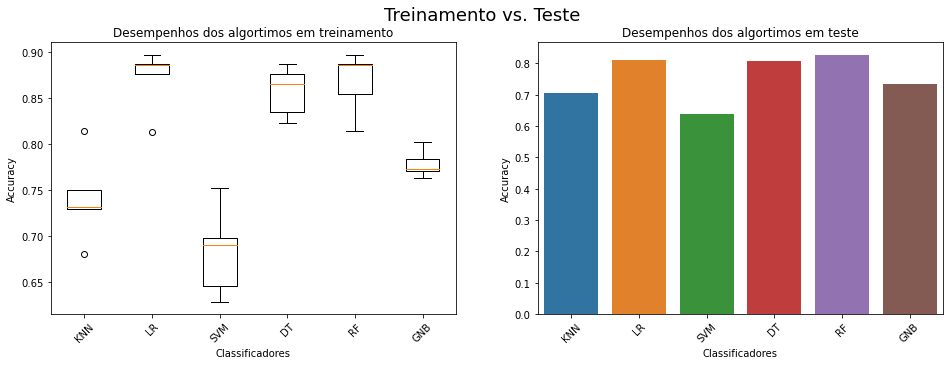

In [30]:
#Canvas para criação dos gráficos
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,5))
fig.suptitle('Treinamento vs. Teste', fontsize=18)

#Gráfico Treino
ax1.boxplot(results_train)
ax1.set_xticklabels(names, rotation=45)
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Classificadores')
ax1.set_title('Desempenhos dos algortimos em treinamento')

#Gráfico Teste
df = pd.DataFrame((zip(names, results_test)),columns = ['Classificadores','Accuracy_teste'])
df.set_index('Classificadores',inplace=True)

ax2 = sns.barplot(x=df.index,y=df.Accuracy_teste)
ax2.set_xticklabels(names,rotation=45)
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Classificadores')
_=ax2.set_title('Desempenhos dos algortimos em teste')

### 8.4. Matriz de Confusão

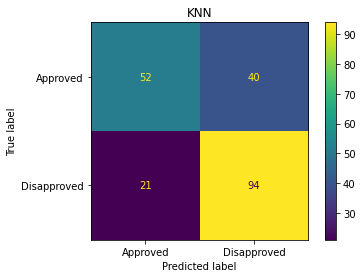

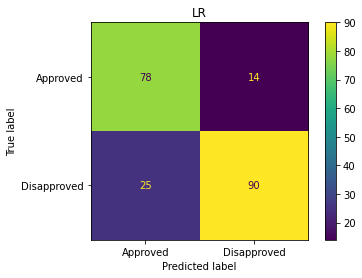

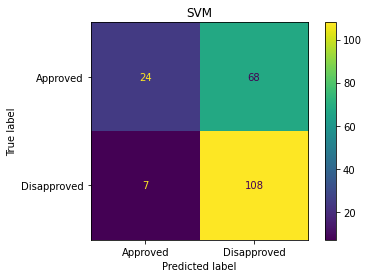

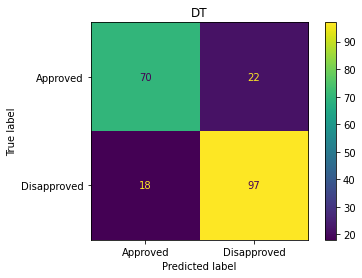

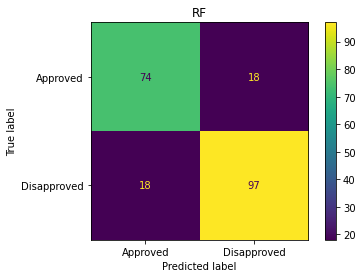

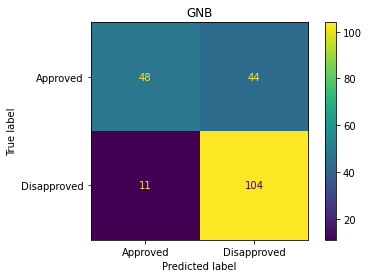

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

class_names = ['Approved','Disapproved']

for  name, model, parameters in classifiers:
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    #print('***** Classification Report:{}*****'.format(name))
    #print(classification_report(y_test, y_pred))
    cm_display.ax_.set_title(name)
    cm_display.ax_.set_xticklabels(class_names)
    cm_display.ax_.set_yticklabels(class_names)

### 8.5. Classification Report

In [32]:
for  name, model, parameters in classifiers:
    y_pred = model.predict(X_test)
    print('CLASSIFICATION REPORT'+'     *****   {}   *****'.format(name))   
    print(classification_report(y_test, y_pred,digits=5))
    print('')

CLASSIFICATION REPORT     *****   KNN   *****
              precision    recall  f1-score   support

           0    0.71233   0.56522   0.63030        92
           1    0.70149   0.81739   0.75502       115

    accuracy                        0.70531       207
   macro avg    0.70691   0.69130   0.69266       207
weighted avg    0.70631   0.70531   0.69959       207


CLASSIFICATION REPORT     *****   LR   *****
              precision    recall  f1-score   support

           0    0.75728   0.84783   0.80000        92
           1    0.86538   0.78261   0.82192       115

    accuracy                        0.81159       207
   macro avg    0.81133   0.81522   0.81096       207
weighted avg    0.81734   0.81159   0.81218       207


CLASSIFICATION REPORT     *****   SVM   *****
              precision    recall  f1-score   support

           0    0.77419   0.26087   0.39024        92
           1    0.61364   0.93913   0.74227       115

    accuracy                        0.63768

## 9. Escolha do modelo

### As métricas analisadas apontam que o classificador com o melhor desempenho foi o LogisticRegression() com acurácias em treino e teste, respectivamente, de 87,15% e 81,16%. 

### Observa-se que as outras métricas de avaliação, tais como precision, recall e F1-score() do classificador também se apresentaram de forma tal que os falsos negativos e falsos positivos são minimizados em relação aos demais classificadores analisados, e podem ser visuazliadas nos classfications reports e matrizes de confusão supracitados.

In [54]:
classifiers = classifiers[1:2]
for name, model, parameters in classifiers:
    print('>> classifier name: {}'.format(name))
    gs = GridSearchCV(estimator=model, param_grid=parameters, refit=True, verbose=0)
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    cv = cross_val_score(gs, X_train, y_train, cv=kf, scoring='accuracy')
    print('Mean Accuracy: {:.2f}%, Standard Deviation: {}'.format(cv.mean()*100,cv.std()))
    results_train.append(cv)
    names.append(name)

>> classifier name: LR
Mean Accuracy: 87.15%, Standard Deviation: 0.030235973275220682
